In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from random import random

In [2]:
import randomized_ir
import utils
import plots

In [3]:
SAVE_IMAGES = True

In [4]:
from importlib import reload

def reload_modules():
    reload(randomized_ir)
    reload(utils)
    reload(plots)

In [5]:
reload_modules()

## IR

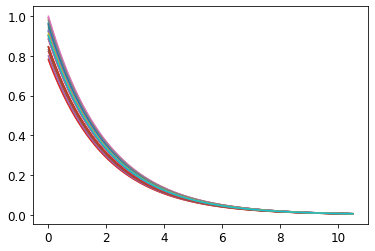

In [6]:
gamma = 0.5

pts_per_bin = 100
L_true = 10.5

ir_x = np.linspace(0, L_true, int(L_true * pts_per_bin))

# exp-decay
ir_y = np.exp(- gamma * ir_x)

# step
# step_witdh = 2
# ir_y = (ir_x < step_witdh).astype('float')

rir = randomized_ir.RandomizedIr(ir_x, ir_y, factor=lambda: 0.75 + random()*0.25)
# rir = randomized_ir.RandomizedIr(ir_x, ir_y)

rir.plot_realizations(count=30)

# Convoluted signal

Pic: `\ref{pic:problem-setup}`


In [7]:
N = 50
n_vec_mean = 15

n_vec = utils.generate_poissonian_ns(n_vec_mean, N)

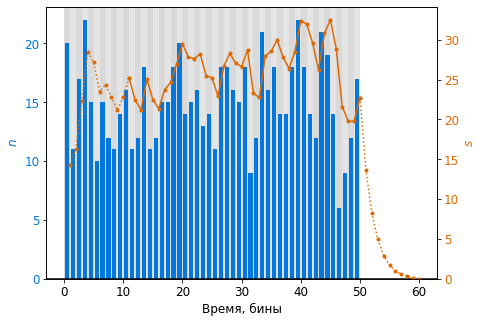

In [8]:
# uniform inbin time distribution:
s_vec = rir.convolve_with_n_vec(n_vec)

# non trivial inbin time distribution:
# S_vec = rir.convolve_with_n_vec(n_vec, inbin_invcdf=lambda x: x**(1/10), debug_inbin_times=True)

filename = 'problem-setup-example' if SAVE_IMAGES else None

plots.plot_convolution(n_vec, s_vec, filename=filename)

# Mean-based estimation

Chapter: `Грубая оценка методом наименьших квадратов`

In [9]:
stats = randomized_ir.RandomizedIrStats(rir, samplesize=100000)

n_vec_estimation = stats.estimate_n_vec(s_vec)

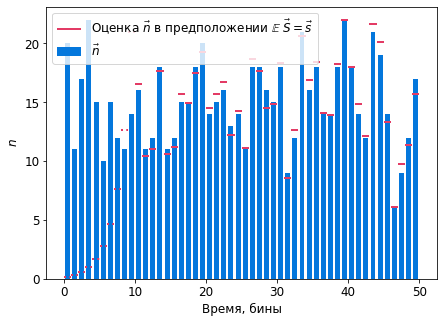

In [10]:
filename = 'mean-estimation' if SAVE_IMAGES else None
plots.plot_mean_n_estimation(n_vec, n_vec_estimation, stats.L, filename=filename)

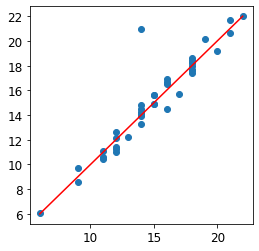

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))

cut_n_vec = utils.slice_edge_effects(n_vec, stats.L, N)
cut_n_vec_estimation = utils.slice_edge_effects(n_vec_estimation, stats.L, N)

ax.scatter(cut_n_vec, cut_n_vec_estimation)

n_minmax = np.linspace(cut_n_vec.min(), cut_n_vec.max(), 4)
ax.plot(n_minmax, n_minmax, 'r-')

plt.show()

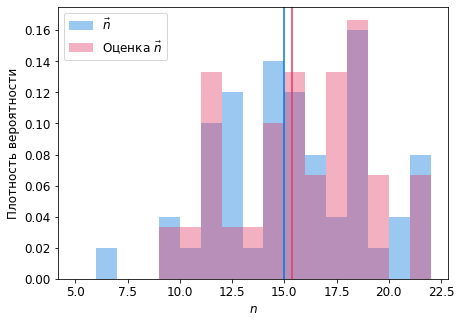

In [12]:
# filename = 'mean-estimation-assessment'
filename = None
plots.plot_mean_n_estimation_assessment(n_vec, n_vec_estimation, L=stats.L, filename=filename)

# MCMC-based estimation

Assuming $S_j$ are close to normal

In [13]:
logL = stats.get_loglikelihood_normdist(s_vec)

logL(n_vec_estimation)

-5.892644479550368e-26

In [14]:
# see https://emcee.readthedocs.io/en/stable/user/sampler/

import emcee

rng = np.random.default_rng()

n_walkers = 128

spread_from_estimation = 3  # from n_vec_estimation
n_starting_points = np.tile(n_vec_estimation, (n_walkers, 1)) + rng.normal(scale=spread_from_estimation, size=(n_walkers, N))

sampler = emcee.EnsembleSampler(n_walkers, N, logL)

In [15]:
sampler.run_mcmc(n_starting_points, 10000)

print('done!')

/home/njvh/Documents/Science/sphere/detector-model/deconvolution/rirenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
done!


In [16]:
reload_modules()

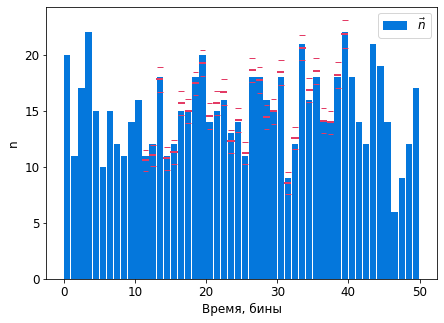

In [17]:
sample = sampler.get_chain(flat=True, thin=2, discard=1000)

plots.plot_bayesian_mean_estimation(n_vec, sample, stats.L)

In [18]:
sample.shape

(576000, 50)

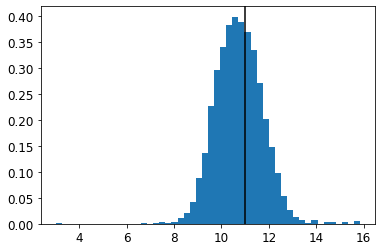

In [19]:
fig, ax =  plt.subplots()

ibin = 14

ax.hist(sample[:, ibin], bins=50, density=True)
ax.axvline(n_vec[ibin], color='black')